In [1]:
%matplotlib inline

In [2]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [3]:
G = build_karate_club_graph()
print("We have %d nodes." % G.number_of_nodes())
print("We have %d edges." % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


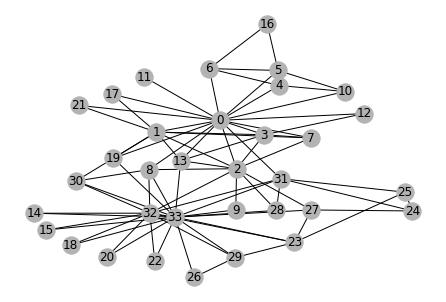

In [4]:
import networkx as nx
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [5]:
import torch
G.ndata['feat'] = torch.eye(34)

In [6]:
print(G.nodes[2].data['feat'])
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

def gcn_message(edges):
    return {'msg': edges.src['h']}

def gcn_reduce(nodes):
    return {'h': torch.sum(nodes.mailbox['msg'], dim=1)}

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        g.ndata['h'] = inputs
        g.send(g.edges(), gcn_message)
        g.recv(g.nodes(), gcn_reduce)
        h = g.ndata.pop('h')
        return self.linear(h)

In [8]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
net = GCN(34, 5, 2)

In [9]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch %d, Loss: %.4f" % (epoch, loss.item()))

/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0, Loss: 1.0001
Epoch 1, Loss: 0.5586
Epoch 2, Loss: 0.2934
Epoch 3, Loss: 0.1545
Epoch 4, Loss: 0.0839
Epoch 5, Loss: 0.0456
Epoch 6, Loss: 0.0257
Epoch 7, Loss: 0.0151
Epoch 8, Loss: 0.0093
Epoch 9, Loss: 0.0060
Epoch 10, Loss: 0.0040
Epoch 11, Loss: 0.0028
Epoch 12, Loss: 0.0020
Epoch 13, Loss: 0.0014
Epoch 14, Loss: 0.0011
Epoch 15, Loss: 0.0008
Epoch 16, Loss: 0.0007
Epoch 17, Loss: 0.0005
Epoch 18, Loss: 0.0004
Epoch 19, Loss: 0.0004
Epoch 20, Loss: 0.0003
Epoch 21, Loss: 0.0003
Epoch 22, Loss: 0.0002
Epoch 23, Loss: 0.0002
Epoch 24, Loss: 0.0002
Epoch 25, Loss: 0.0001
Epoch 26, Loss: 0.0001
Epoch 27, Loss: 0.0001
Epoch 28, Loss: 0.0001
Epoch 29, Loss: 0.0001


/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


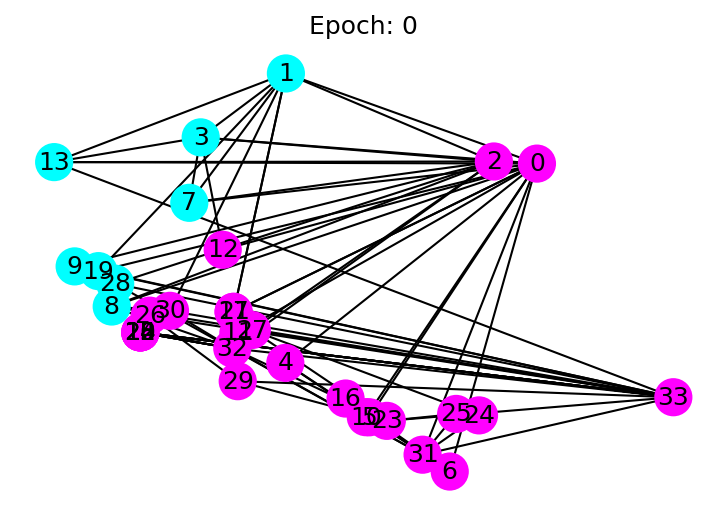

In [11]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
#plt.close()

In [12]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


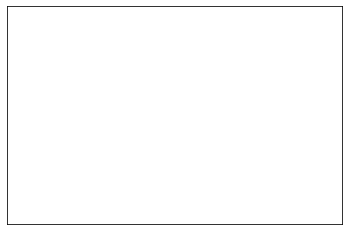

In [13]:
from IPython.display import HTML
HTML(ani.to_html5_video())